# Compare Snow depth Maps Example

**Goal**: Use the USGS Snow off and the ASO snow off to calculate a snow depth raster. Compare them.

**Approach**: 

1. Get a buffered square centered on a pit
2. Gather the snow on raster within the buffered pit 
3. Gather the snow off rasters within the snow on boundary 
4. Evaluate the snow off rasters
5. Create the snow depth maps
6. Plot snow depths

## Process:

### Step 1. Get a buffered square centered on a pit

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, SiteData
from rasterio.plot import show

from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio, points_to_geopandas, query_to_geopandas, crop, resample
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import rasterio.mask
import tempfile
from matplotlib.image import AxesImage

# Pit Site Identifier of interest
site_id = '1S1'

# Distance around the pit to collect data in meters
buffer_dist = 100

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_id==site_id)
sites = q.all()

# Grab the pit location from a single layer
p = to_shape(sites[0].geom)

# Build a polygon  using the buffer distance 
x1 = p.x - buffer_dist
y1 = p.y - buffer_dist
x2 = p.x + buffer_dist
y2 = p.y + buffer_dist

# Make two versions. 1 for working directly with the DB and one for plotting
buffer_shp = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely
buffered_pit = from_shape(buffer_shp, srid=26912).ST_AsEWKT()        # Save one for the database
buffered_pit_df = gpd.GeoDataFrame({'geometry':[buffer_shp, p]})     # Save one for plotting


### Step 2. Gather the Snow on raster within the Buffered Pit 

In [2]:
# Grab the snow on from QSI union them and convert them as tiff when done
s = func.ST_Clip(gfunc.ST_Union(ImageData.raster, type_=Raster), buffered_pit)

# Return the Polygon of the boundary and the raster
q = session.query(func.ST_Envelope(s), func.ST_AsTiff(s))

# Filter by the data name
q = q.filter(ImageData.type == 'bare earth digital elevation models')

# Filter to QSI as the surveyors
q = q.filter(ImageData.surveyors == 'Quantum Spatial Inc.')

# Only grab the raster tiles in the buffered pit
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffered_pit))
records = q.all()

# Get the shape of the resulting raster boundary
snow_on_boundary = to_shape(records[0][0])
boundary_EWKT = from_shape(snow_on_boundary, srid=26912).ST_AsEWKT()

# Convert the resulting image to a rasterio dataset
rasters = [[records[0][1]]]
snow_on = raster_to_rasterio(session, rasters)[0]
print('QSI Snow On raster {} X {} Res = {}x{}'.format(snow_on.width, snow_on.height, snow_on.res[0], snow_on.res[1]))

# Retrieve the original resolution 
q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
res = q.filter(ImageData.type == 'bare earth digital elevation models').filter(ImageData.surveyors == 'Quantum Spatial Inc.').limit(1).all()
print('Original Resolution = {} x {}'.format(res[0][0], res[0][1]))


QSI Snow On raster 400 X 400 Res = 0.5x0.5
Original Resolution = 0.5 x 0.5


### Step 3A. Define a function to gather the snow off rasters within the domain of the snow on raster 

In [3]:
# Define a function to retrieve a resampled and clip dataset the same way the snow on data is.

def retrieve_matched_raster(data_name, surveyors, polygon, res):
    '''
    Gather all rasters filted by name and surveyors that intersect the polygon. Resample to the resolution provided
    and clip to the polygon
    '''
    
    # Retrieve the original resolution 
    q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
    res_o = q.filter(ImageData.type == data_name).filter(ImageData.surveyors == surveyors).limit(1).all()
    print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))
    
    # Return a Tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
    s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster, type_=Raster), res[0], -1 * res[1],  algorithm='bilinear'), polygon)

    # Filter by surveyors and data name DEM
    q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    
    # Grab all tile that intersect the snow on boundary
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))
    records = q.all()

    # Convert to Rasterio 
    dataset = raster_to_rasterio(session, records)[0]
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)
    return dataset

### Step 3B. Gather the snow off rasters within the domain of the snow on raster

In [4]:
# Gather the USGS Snow off dem, clip and resample to be the same shape and dimension as the snow on
print('\nUSGS:')
usgs_snow_off = retrieve_matched_raster('snow off digital elevation model', 'USGS', boundary_EWKT, snow_on.res)
usgs = usgs_snow_off.read(1)

# Gather the ASO snow off dem, clip and resample to be the same shape and dimension as the snow on
print('\nASO:')
aso_snow_off = retrieve_matched_raster('snow off digital elevation model', 'Airborne Snow Observatory', boundary_EWKT, snow_on.res)

# The ASO data NAN is -9999, replace those with python nans
aso = aso_snow_off.read(1)[0:usgs.shape[0], 0:usgs.shape[1]]
nan_ind = aso == -9999
aso[nan_ind] = np.nan


USGS:
Original Resolution = 1.0 x1.0
Raster 400 X 400, Final Res = 0.5 x 0.5
BoundingBox(left=741820.0, bottom=4322745.0, right=742020.0, top=4322945.0)

ASO:
Original Resolution = 2.999870551816784 x2.999870551816784
Raster 401 X 401, Final Res = 0.5 x 0.5
BoundingBox(left=741819.7561938388, bottom=4322744.707817027, right=742020.2561938388, top=4322945.207817027)


### Step 4. Evaluate the snow off rasters

Difference Map:
	mean = 0.6956920623779297
	min = 0.345703125
	max = 1.93310546875
	std = 0.14397837221622467


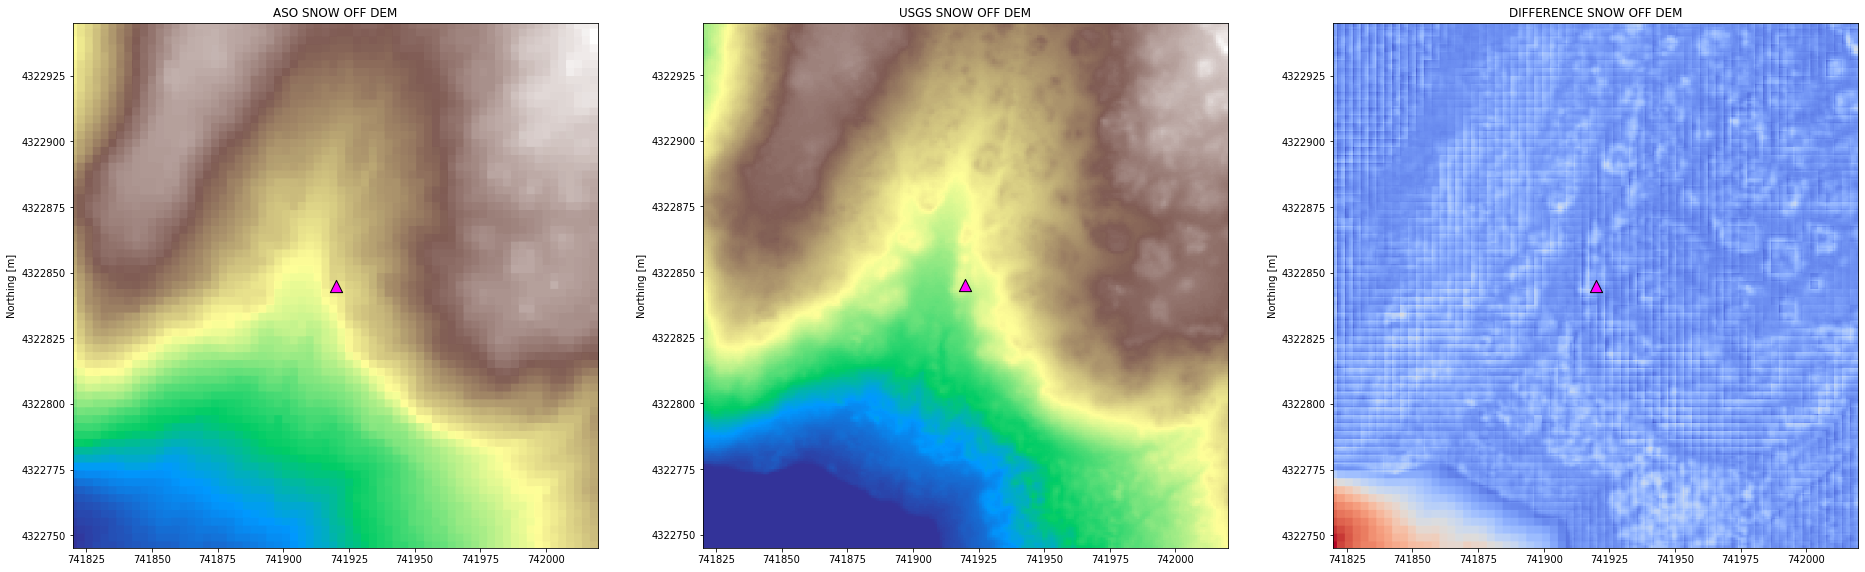

In [5]:
# Plot these to confirm we have something similar
rasters = {'aso':(aso, aso_snow_off.transform), 
           'usgs':(usgs, usgs_snow_off.transform),
           'difference': (usgs - aso, aso_snow_off.transform)}

fig, axes = plt.subplots(1,len(rasters.keys()), figsize=(32, 16))
i = 0 

for name, dst in rasters.items():
    
    # Color the difference map differently and print out smoe stats
    if name == 'difference':
        
        cmap = 'coolwarm'
        print('Difference Map:')
        
        for stat in ['mean', 'min', 'max','std']:
            result = getattr(dst[0], stat)()
            print('\t{} = {}'.format(stat, result))
    else:
        cmap = 'terrain'
    
    # Plot the raster
    show(dst[0], transform=dst[1], cmap=cmap, ax=axes[i])
    
    # Plot the pit location on top of each snow off raster
    buffered_pit_df.iloc[1:].plot(ax=axes[i], marker='^', color='magenta',  markersize=150, edgecolor='black')
    
    # Don't use scientific notation on the axis ticks
    axes[i].ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    axes[i].set_ylabel('Northing [m]')
    axes[i].set_title('{} SNOW OFF DEM'.format(name.upper()))
    
    # Iterate the index for the subplot number
    i += 1

# Assign the snow on raster to our dictionary for convenience
rasters['QSI'] = (snow_on.read(1), snow_on.transform)

### Step 5. Create the snow depth maps

In [6]:
# Assign the snow on dem
snow_dem = rasters['QSI'][0]

# Calculate the snow depth maps
usgs_depths = snow_dem - rasters['usgs'][0]
aso_depths = snow_dem - rasters['aso'][0]

# Calculate a difference map
diff = aso_depths - usgs_depths

### Step 6. Plot snow depths

No handles with labels found to put in legend.
No handles with labels found to put in legend.


USGS
	mean = 0.7154524922370911
	min = -0.659912109375
	max = 1.3359375
	std = 0.20145462453365326
ASO
	mean = 1.411144495010376
	min = 0.755126953125
	max = 2.044921875
	std = 0.1527397483587265


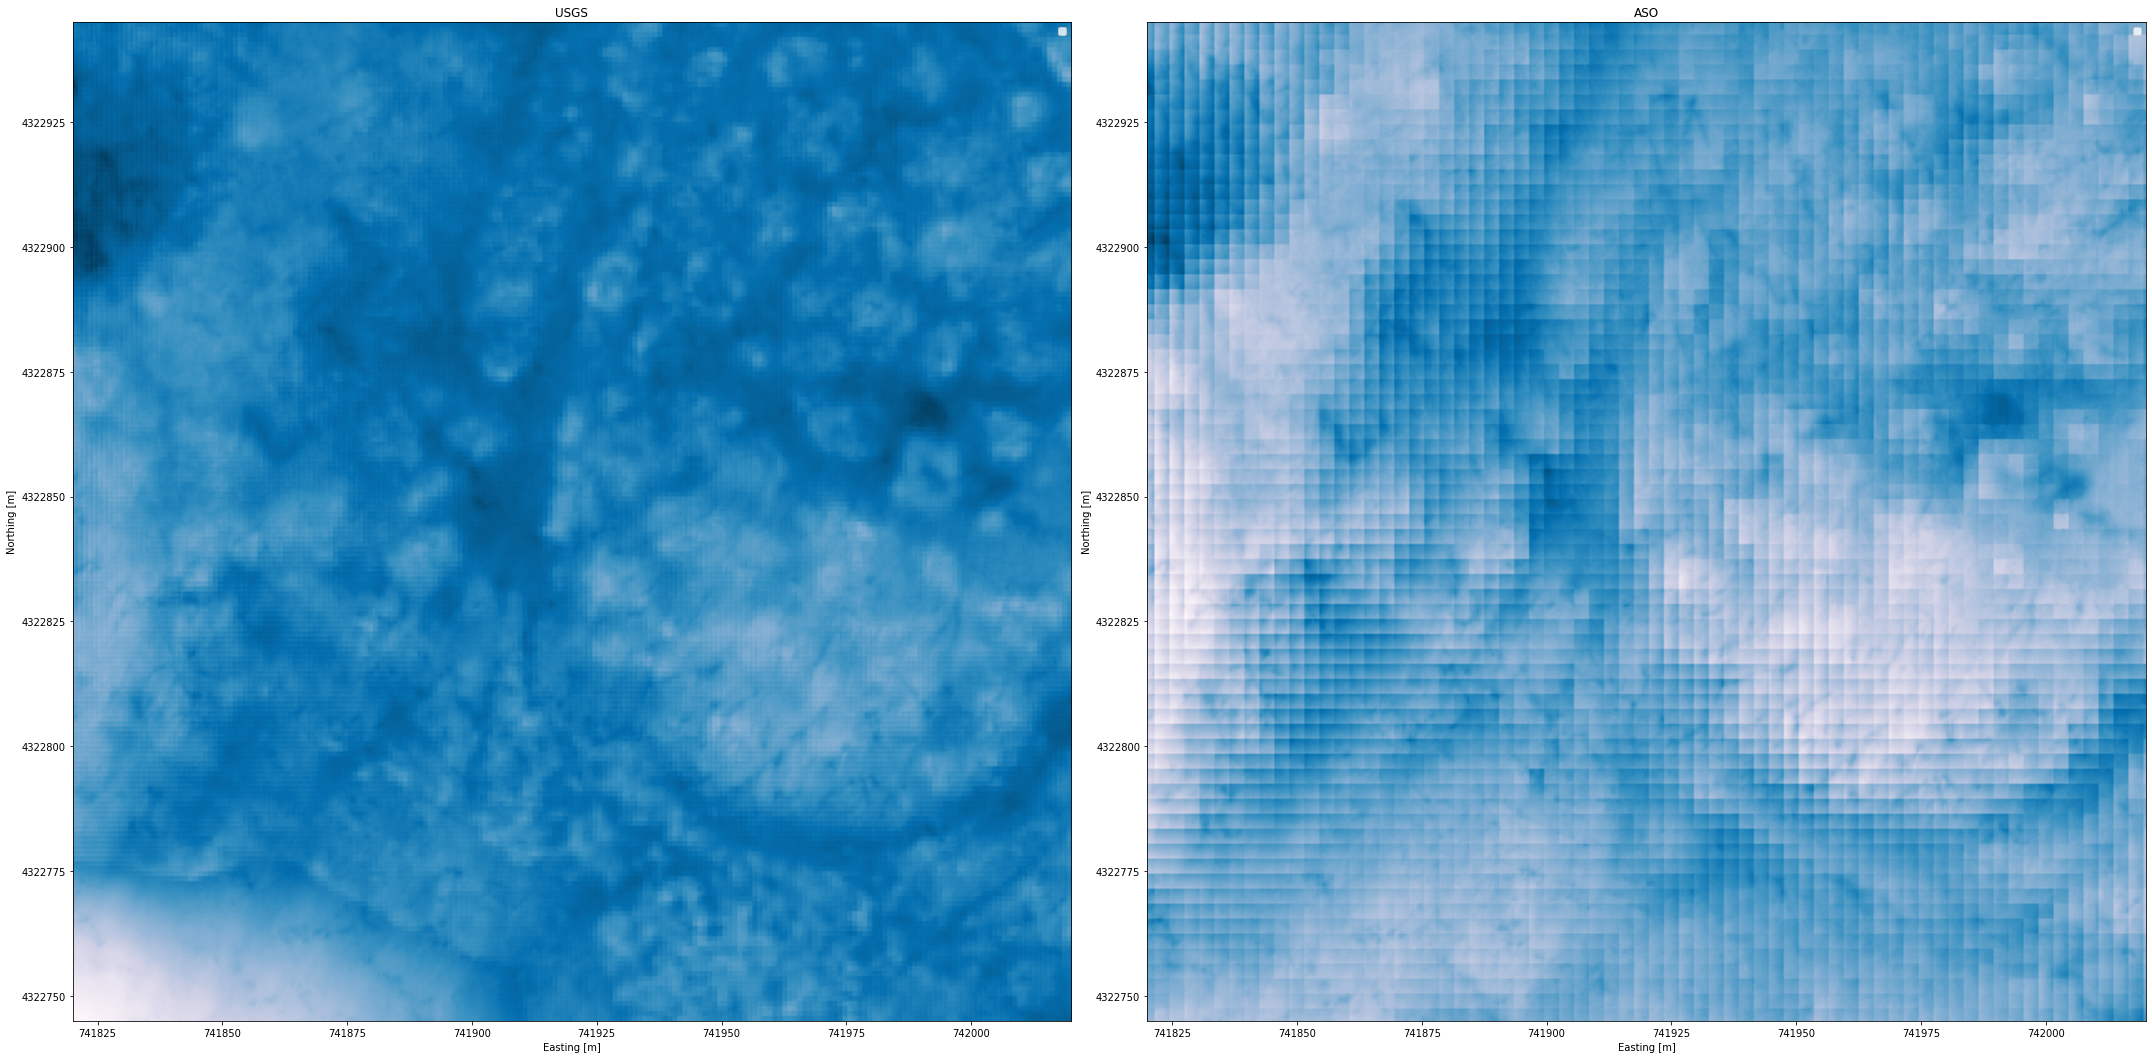

In [7]:
# Create a single plot to add everything to
data = {'usgs': usgs_depths, 'aso':aso_depths}

# Make the plot a certain height
h = 15
# Make the number of subplots the same as the dictionary of data
nplots = len(data.keys())
fig, axes = plt.subplots(1, nplots, figsize=(2 * h, h))

# plot indexer
i = 0 

# Colormap
cmap = 'PuBu'

# Plot the Snow Depths
for name, img in data.items():
    
    # Grab the subplot object
    ax = axes[i]
    
    # Plot the raster using rasterio and the transform
    show(img, ax=ax, cmap=cmap, transform=snow_on.transform)
        
    # Perform some Stats
    print(name.upper())
    for stat in ['mean','min','max','std']:
        print('\t{} = {}'.format(stat, getattr(img, stat)()))
    
    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(name.upper())
    ax.legend()

    i += 1
    
# bar = fig.colorbar(img)    
plt.tight_layout()


In [8]:
# Close out the database transaction to avoid hanging transactions
session.close()
